# Camera Calibration

In [22]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

objpoints = [] # 3D points
imgpoints = [] # 2D points

n_x = 9
n_y = 6

objp = np.zeros((n_x*n_y,3), np.float32)
objp[:,:2] = np.mgrid[0:n_x,0:n_y].T.reshape(-1,2) # x,y co-ordinates

# Step 1: Read in calibration images provided
fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Step 2: 
    ret, corners = cv2.findChessboardCorners(gray, (n_x,n_y), None) # returns corners in gray scale
    if ret:
        objpoints.append(objp) # same for all chessboard images
        imgpoints.append(corners)
        
# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
#ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2],None,None)



# Test Calibration

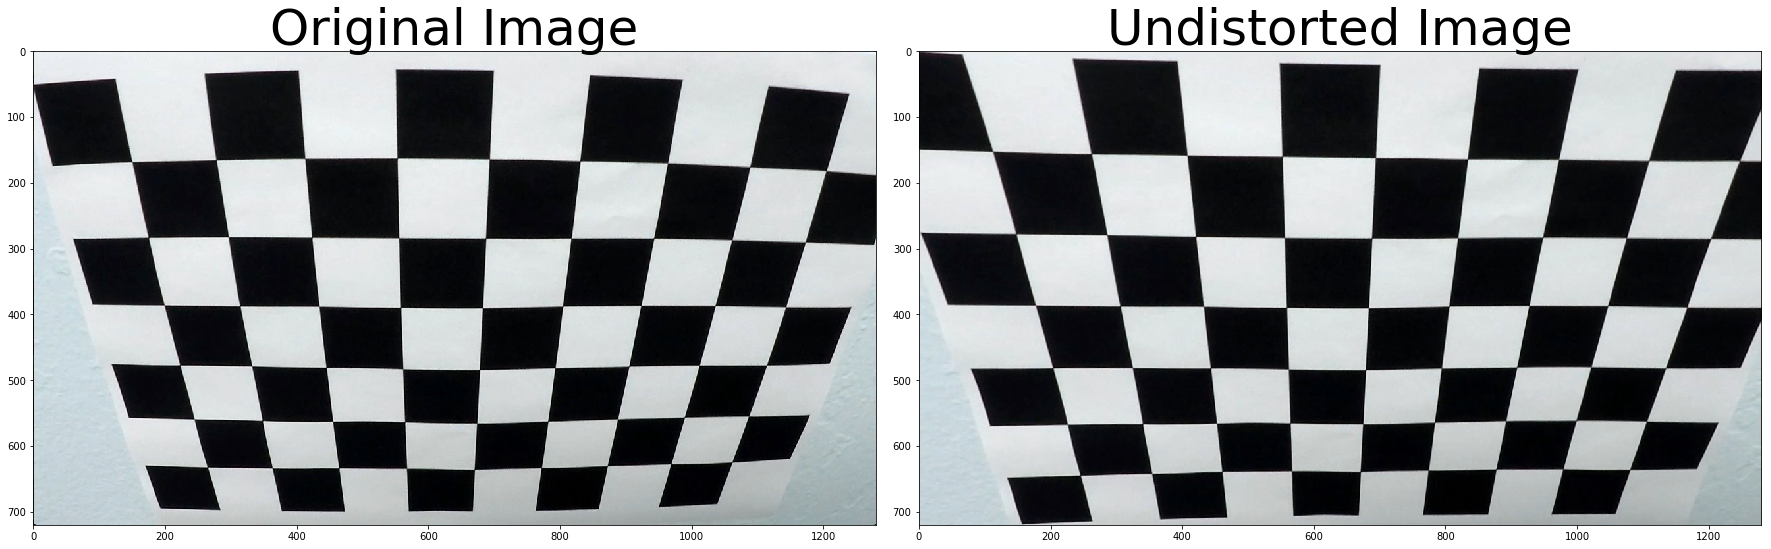

In [23]:


# Read in the saved objpoints and imgpoints

# Read in an image
img = cv2.imread('camera_cal/calibration2.jpg')


def cal_undistort(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    dst = cv2.undistort(img, mtx, dist, None, mtx)  # use the matrix calculated in prior step
    undist = np.copy(dst)
    return undist

undistorted = cal_undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Combined Image

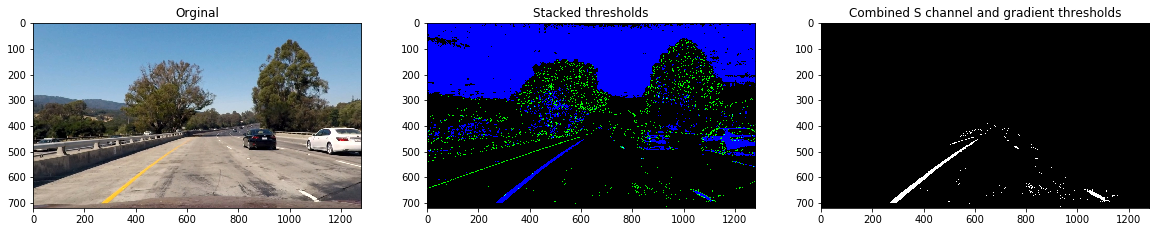

In [24]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt


_img = mpimg.imread('test1.jpg') 

#_img = mpimg.imread('test1.jpg') 

#img = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
img = cal_undistort(_img)

#RM: Get the gray image for sobel operations-----sobel----start (sxbinary)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
height, width = gray.shape
# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sx_binary = np.zeros_like(scaled_sobel)
sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

#RM: Get the gray image for sobel operations-----sobel----end

#RM: Get the gray image for sobel operations-----sobel directional -- start
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
# 3) Take the absolute value of the x and y gradients
abs_sobel_x = np.absolute(sobel_x)
abs_sobel_y = np.absolute(sobel_y)
# 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
direction = np.arctan2(abs_sobel_y, abs_sobel_x)
direction = np.absolute(direction)
# 5) Create a binary mask where direction thresholds are met
mask = np.zeros_like(direction)
mask[(direction >= np.pi/6) & (direction <= np.pi/2)] = 1
#RM: Get the gray image for sobel operations-----sobel directional -- end


# combine the gradient and direction thresholds.
sxd_binary = np.zeros_like(scaled_sobel)
sxd_binary = ((sx_binary == 1) & (mask == 1))

#RM: Get the s channel --- start

# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
# Threshold color channel
s_channel = hls[:,:,2]
s_thresh_min = 120
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

#RM: Get the s channel --- end

#RM: Get the l channel --- start
l_channel = hls[:,:,1]
l_thresh_min = 120
l_thresh_max = 255
l_binary = np.zeros_like(s_channel)

l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

#RM: Get the l channel --- end
# Combine s and l channel ( l channel is helpful to remove tree shadows)    
sl_binary = s_binary & l_binary

#RM: Get the r & g channel --- start
color_threshold = 170
red = img[:,:,0]
green = img[:,:,1]
rg_combined = np.zeros_like(red)
rg_condition = (red > color_threshold) & (green > color_threshold)
#RM: Get the r & g channel --- end    

#RM: Combine/stack --- start
# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxd_binary), sxd_binary, s_binary)) * 255

# Combine the two binary thresholds
_combined_binary = np.zeros_like(sx_binary)
#combined_binary[(sl_binary == 1) | (sxd_binary == 1)] = 1
_combined_binary[((rg_condition ==1 ) & (sl_binary == 1)) | (sxd_binary == 1)] = 1

mask = np.zeros_like(_combined_binary)
combined_binary = np.zeros_like(_combined_binary)
region_of_interest_vertices = np.array([[200,height-1], 
                                        [width/2, int(0.5*height)], 
                                        [width, height-1]], dtype=np.int32)
cv2.fillPoly(mask, [region_of_interest_vertices], 1)
combined_binary[((_combined_binary==1) & (mask==1))]=1

#RM: Plot--- start
# Plotting thresholded images
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,10))
ax0.set_title('Orginal')
ax0.imshow(img)

ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Perspective

h,w720,1280


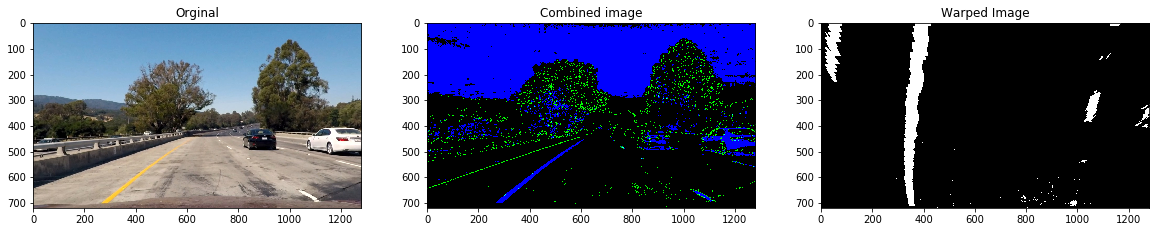

In [25]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt

#combined_binary = thresholded
img_size = combined_binary

img_size[1], img_size[0] = img.shape[:2]
h,w = img.shape[:2]
print ('h,w'+str(h)+','+str(w))

#Manual point calculation (picked up from one of the forum posts)
#happen to try a lot and ulimatley this works
#------------------
src = np.array([[585,460],[203,720],[1127,720],[695,460]],np.float32)
dst = np.array([[320,0],[320,720],[960,720],[960,0]],np.float32)


M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
binary_warped = cv2.warpPerspective(combined_binary, M, (w, h), flags=cv2.INTER_LINEAR)


f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,10))
ax0.set_title('Orginal')
ax0.imshow(img)

ax1.set_title('Combined image')
ax1.imshow(color_binary)

ax2.set_title('Warped Image')
ax2.imshow(binary_warped, cmap='gray')

# Polynomial 

(720, 0)

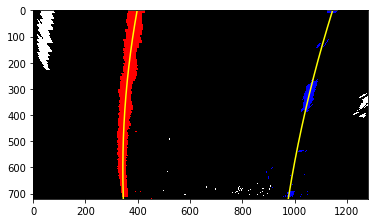

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt



# RM : histogram calculation
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

midpoint = np.int(histogram.shape[0]/2)
#print(midpoint)
leftx_base = np.argmax(histogram[0:midpoint])
rightx_base = np.argmax(histogram[midpoint:1100]) + midpoint


# Choose the number of sliding windows
nwindows = 11
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 140
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    #(0,255,0), 2) 
    #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    #(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Curvature

In [27]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calc_curv_radius(fitx) : 
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    # Now our radius of curvature is in meters
    return curverad

In [28]:
ll_c_r = calc_curv_radius(left_fitx)
rl_c_r = calc_curv_radius(right_fitx)
print (ll_c_r)
print (rl_c_r)

1111.19317908
1533.46903262


# Lane Test Images

In [33]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
import matplotlib.image as mpimg
import numpy as np
import cv2
import matplotlib.pyplot as plt



def pipeline(_img):
    global left_fitx_o, right_fitx_o
    img= cal_undistort(_img)
    #RM: Get the gray image for sobel operations-----sobel----start (sxbinary)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    #RM: Get the gray image for sobel operations-----sobel directional -- start
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= np.pi/6) & (direction <= np.pi/2)] = 1
    #RM: Get the gray image for sobel operations-----sobel directional -- end
    sxd_binary = ((sx_binary == 1) & (mask == 1))

    #RM: Get the gray image for sobel operations-----sobel----end

    #RM: Get the s channel --- start

    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Threshold color channel
    s_channel = hls[:,:,2]
    s_thresh_min = 120
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    #RM: Get the s channel --- end
    
    
    #RM: Get the l channel --- start
    l_channel = hls[:,:,1]
    l_thresh_min = 120
    l_thresh_max = 255
    l_binary = np.zeros_like(s_channel)

    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    #RM: Get the l channel --- end
    # Combine s and l channel ( l channel is helpful to remove tree shadows)    
    sl_binary = s_binary & l_binary

    #RM: Get the r & g channel --- start
    color_threshold = 170
    red = img[:,:,0]
    green = img[:,:,1]
    rg_combined = np.zeros_like(red)
    rg_condition = (red > color_threshold) & (green > color_threshold)
    #RM: Get the r & g channel --- end    
    
    #RM: Combine/stack --- start
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxd_binary), sxd_binary, sl_binary)) * 255

    # Combine the three binary thresholds
    combined_binary = np.zeros_like(sx_binary)
    combined_binary[((rg_condition ==1 ) & (sl_binary == 1)) | (sxd_binary == 1)] = 1

    #img_size = combined_binary
    #img_size[1], img_size[0] = img.shape[:2]


    #Manual point calculation 
    src = np.array([[585,460],[203,720],[1127,720],[695,460]],np.float32)
    dst = np.array([[320,0],[320,720],[960,720],[960,0]],np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    h,w = img.shape[:2]
    binary_warped = cv2.warpPerspective(combined_binary, M, (w, h), flags=cv2.INTER_LINEAR)


    # RM : histogram calculation
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    midpoint = np.int(histogram.shape[0]/2)
    #print(midpoint)
    leftx_base = np.argmax(histogram[0:midpoint])
    rightx_base = np.argmax(histogram[midpoint:1100]) + midpoint


    # Choose the number of sliding windows
    nwindows = 11
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 140
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]  
    
   
    if ( (len(left_fitx_o) ==0) and (len(right_fitx_o)==0) ) :
        left_fitx_o = left_fitx
        right_fitx_o = right_fitx

    
    # Calculate the curvature
    ll_c_r = calc_curv_radius(left_fitx)
    rl_c_r = calc_curv_radius(right_fitx)
    
    c_c_r = (ll_c_r + rl_c_r) /2
    # if curvatures are far apart, use prior points,
    # else store the last good knows points
    
    #if(abs(rl_c_r-2000)>ll_c_r) :
    #    right_fitx = left_fitx
    if (abs(ll_c_r - rl_c_r)>500.00) :
        left_fitx = left_fitx_o
        right_fitx = right_fitx_o
    else :
        left_fitx_o = left_fitx
        right_fitx_o = right_fitx

        
    # Create an image to draw the lines on

    Minv = cv2.getPerspectiveTransform(dst, src)

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)

    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))



    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,0, 255))


    # Warp it back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    curv = 'Curvature:'+str(round(ll_c_r,4))
    # Center offset
    c = (left_fitx[719] + right_fitx[719])/2
    h1,w1=result.shape[::2]
    c_1 = abs(int(w1/2 - c))
    c_2 = round(xm_per_pix*c_1,4)
    center = "Center offset:" + str(c_2)

    
    cv2.putText(result, curv , (150, 100) , cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,0), thickness=2)
    #cv2.putText(result, str(round(ll_c_r,2)) , (150, 100) , cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,0), thickness=2)
    #cv2.putText(result, str(round(rl_c_r,2)) , (150, 150) , cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,0), thickness=2)
    cv2.putText(result, center , (150, 200) , cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), thickness=2)

    
    return result

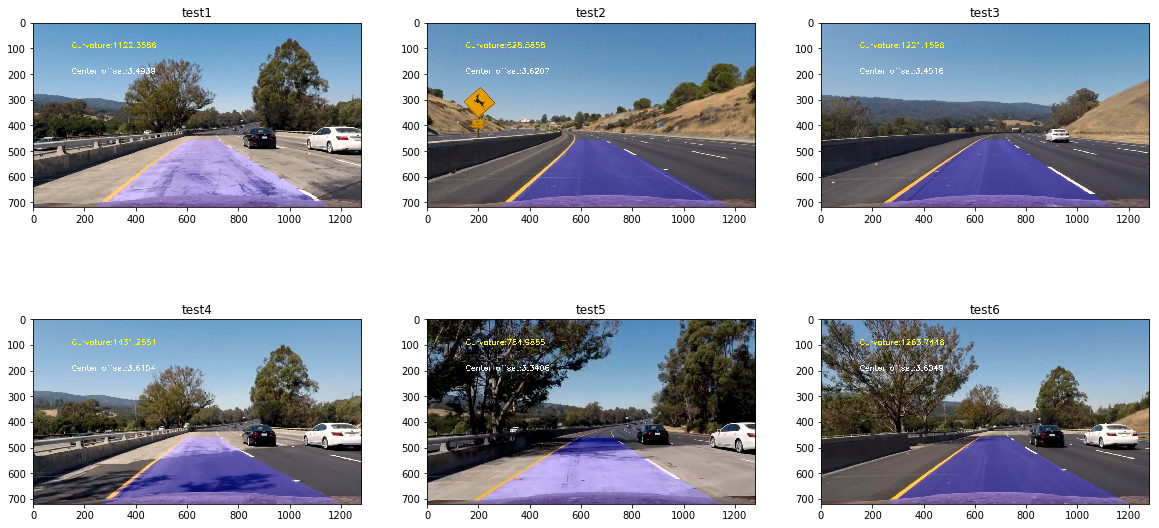

In [34]:
f, axes = plt.subplots(2, 3, figsize=(20,10))
left_fitx_o=[]
right_fitx_o=[]
axes[0,0].set_title('test1')
img = mpimg.imread('test1.jpg') 
result = pipeline(img)
axes[0,0].imshow(result)

left_fitx_o=[]
right_fitx_o=[]
axes[0,1].set_title('test2')
img = mpimg.imread('test2.jpg') 
result = pipeline(img)
axes[0,1].imshow(result)


left_fitx_o=[]
right_fitx_o=[]
axes[0,2].set_title('test3')
img = mpimg.imread('test3.jpg') 
result = pipeline(img)
axes[0,2].imshow(result)

left_fitx_o=[]
right_fitx_o=[]
axes[1,0].set_title('test4')
img = mpimg.imread('test4.jpg') 
result = pipeline(img)
axes[1,0].imshow(result)

left_fitx_o=[]
right_fitx_o=[]
axes[1,1].set_title('test5')
img = mpimg.imread('test5.jpg') 
result = pipeline(img)
axes[1,1].imshow(result)

left_fitx_o=[]
right_fitx_o=[]
axes[1,2].set_title('test6')
img = mpimg.imread('test6.jpg') 
result = pipeline(img)
axes[1,2].imshow(result)


# Movie generation

In [35]:

from moviepy.editor import VideoFileClip
left_fitx_o=[]
right_fitx_o=[]
output = 'project_video_final.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [09:06<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

Wall time: 9min 9s
